<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#今までの振り返り" data-toc-modified-id="今までの振り返り-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>今までの振り返り</a></span></li><li><span><a href="#ランダムフォレスト" data-toc-modified-id="ランダムフォレスト-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ランダムフォレスト</a></span><ul class="toc-item"><li><span><a href="#zipcodeをtarget-encoding" data-toc-modified-id="zipcodeをtarget-encoding-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>zipcodeをtarget encoding</a></span></li></ul></li><li><span><a href="#地理データ確認" data-toc-modified-id="地理データ確認-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>地理データ確認</a></span></li><li><span><a href="#k近傍法" data-toc-modified-id="k近傍法-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>k近傍法</a></span></li><li><span><a href="#まとめ" data-toc-modified-id="まとめ-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>まとめ</a></span></li></ul></div>

# 課題
川邉雄太

* 選んだ課題： [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction)

In [15]:
#グラフをnotebook内に描画させるための設定
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# pandasでの表示列を増やす
# see: http://uyamazak.hatenablog.com/entry/2016/09/29/163534
pd.set_option("display.max_column", 101)

In [18]:
df_data = pd.read_csv("./kc_house_data.csv", parse_dates=['date'])

## 今までの振り返り

* 欠損値無し
* 異常値もほぼ無し
* zipcodeをpriceでtarget encodingしたLasso回帰（正則化項つき線形回帰）で、maeが10万ドル程度。


## ランダムフォレスト

特段の工夫無しでランダムフォレストを使用する。

index:0
RMSE=133641.461
MAE=72398.385
index:1
RMSE=131984.214
MAE=72787.203
index:2
RMSE=143520.645
MAE=75355.706
index:3
RMSE=136321.066
MAE=72457.046
index:4
RMSE=127681.789
MAE=70124.82


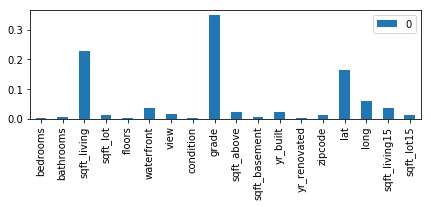

In [9]:
kf = KFold(n_splits=5, random_state=1234, shuffle=True)

for i,(train_index, test_index) in enumerate(kf.split(df_data)):
    drop_columns = ['id', 'date', 'price']
    X = df_data.drop(columns=drop_columns).values
    y = df_data['price'].values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    print('index:{0}'.format(i))
    # print("MSE=%s"%round(mse,3) )
    print("RMSE={0}".format(round(np.sqrt(mse), 3) ))
    print("MAE={0}".format(round(mae,3) ))

plt1 = pd.DataFrame(regr.feature_importances_, index=df_data.drop(columns=drop_columns).columns).plot.bar(figsize=(7,2))

### zipcodeをtarget encoding

index:0
RMSE=131599.788
MAE=71981.065
index:1
RMSE=132359.467
MAE=72056.153
index:2
RMSE=135845.392
MAE=75001.244
index:3
RMSE=126801.965
MAE=70788.721
index:4
RMSE=130716.656
MAE=69903.626


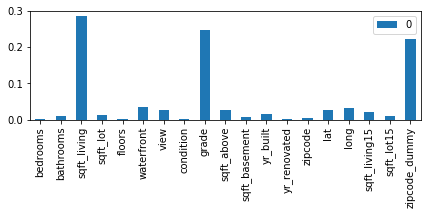

In [19]:
kf = KFold(n_splits=5, random_state=1234, shuffle=True)

for i,(train_index, test_index) in enumerate(kf.split(df_data)):
    df_train = df_data.iloc[train_index]
    zipcode_mean = df_train['price'].groupby(df_train['zipcode']).mean()
    df_data['zipcode_dummy'] =  [zipcode_mean[zipcode] for zipcode in df_data['zipcode']]
    
    drop_columns = ['id', 'date', 'price']
    X = df_data.drop(columns=drop_columns).values
    y = df_data['price'].values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('index:{0}'.format(i))
    # print("MSE=%s"%round(mse,3) )
    print("RMSE={0}".format(round(np.sqrt(mse), 3) ))
    print("MAE={0}".format(round(mae,3) ))
    
pd.DataFrame(regr.feature_importances_, index=df_data.drop(columns=drop_columns).columns).plot.bar(figsize=(7,2))

**ポイント**

* `zipcode` のtarget encoding `zipcode_dummy` を追加した結果、 `zipcode_dummy` の重要度は高くなった。
* しかし `lat` `long` の重要度が減った。
* 結局重要なのは以下３つ。 
  * `sqft_living` 建物の床面積
  * `grade` 建物のグレード
  * 立地（地理）
  
* 地理を確認する。

## 地理データ確認

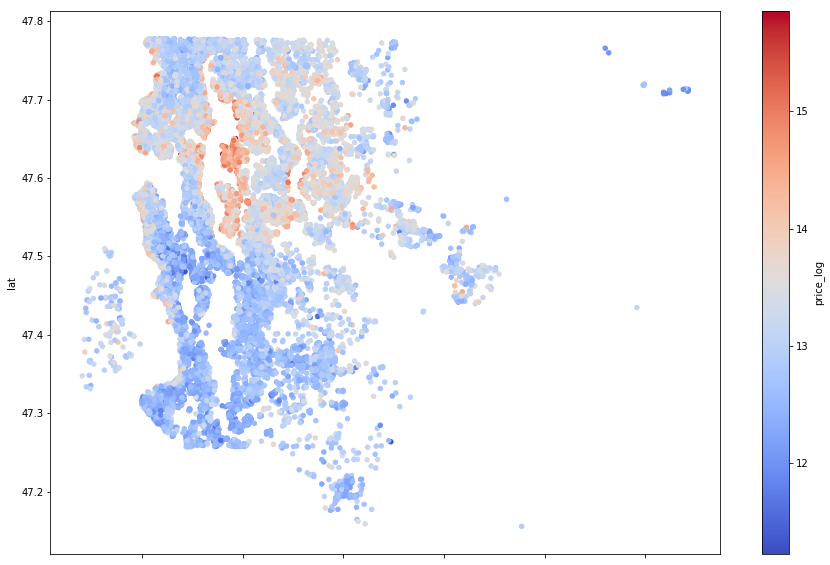

In [17]:
df_data['price_log'] = np.log(df_data['price'])
df_data.plot.scatter(x='long', y='lat', c='price_log', cmap='coolwarm', figsize=(15, 10))

**考えたこと**

* 地理的に近く、また建物が類似している場合は価格も近いのでは？
* それってk近傍法では？

## k近傍法

* 以下４つの変数を使ってk近傍法を使用する。

  * `sqft_living` 建物の床面積
  * `grade` 建物のグレード
  * `lat` 緯度
  * `long` 経度
  
* 注意点として、それぞれの変数の距離計算の尺度が異なる。
  * `lat` が1異なるのと、 `sqft_living` が1異なるのは違う。 `lat` が1異なる方が大きい違いのはず。
  
* 以下のように、`scale_sqft_living` `scale_grade` を用意し、変数に掛け算をして補正する。
 * `X = df_data[['sqft_living', 'grade', 'lat', 'long']].values * [scale_sqft_living, scale_grade, 1, 1]`
 * `lat` `long` はそのまま使えば良い
 
* 通常のk近傍回帰のハイパラメータに加え、良い `scale_sqft_living` `scale_grade` を探すのが今回のタスク。

In [14]:
def KNeighborSearch(parameters):
    results = []
    for param in ParameterGrid(parameters):
        scale = [param['scale_sqft_living'], param['scale_grade'], param['scale_yr_built'], 1, 1]
        n_neighbors = param['n_neighbors']

        maes = []
        rmses = []
        for i,(train_index, test_index) in enumerate(kf.split(df_data)):
            X = df_data[['sqft_living', 'grade', 'yr_built', 'lat', 'long']].values * scale
            y = df_data['price'].values
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            neigh = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1, weights=param['weights'], metric=param['metric'])
            neigh.fit(X_train, y_train) 
            y_pred = neigh.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            maes.append(mae)
            rmses.append(rmse)

        # print(param)
        # print("MSE=%s"%round(mse,3) )
        # print("RMSE={0}".format(round(np.mean(rmses), 3) ))
        # print("MAE={0}".format(round(np.mean(maes),3) ))
        results.append((param, np.mean(rmses), np.mean(maes)))
        
    sortedResults = sorted(results, key=lambda result: result[2])
    display(sortedResults[:5])

In [16]:
parameters = {
    'scale_sqft_living': [2.7e-5, 2.8e-5, 2.9e-5, 2.95e-5, 3e-5, 3.3e-5],
    'scale_grade': [0.015, 0.017, 0.018,  0.019, 0.02, 0.025],
    'scale_yr_built': [0],
    'n_neighbors': [13, 15, 17, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'chebyshev'],
}

KNeighborSearch(parameters)

## 以下maeの良い（小さい）上位5つ

[({'metric': 'manhattan',
   'n_neighbors': 15,
   'scale_grade': 0.015,
   'scale_sqft_living': 2.9e-05,
   'scale_yr_built': 0,
   'weights': 'distance'},
  146869.81822159316,
  74582.78164572045),
 ({'metric': 'manhattan',
   'n_neighbors': 15,
   'scale_grade': 0.015,
   'scale_sqft_living': 2.95e-05,
   'scale_yr_built': 0,
   'weights': 'distance'},
  146846.62380358874,
  74592.44597261655),
 ({'metric': 'manhattan',
   'n_neighbors': 17,
   'scale_grade': 0.015,
   'scale_sqft_living': 2.95e-05,
   'scale_yr_built': 0,
   'weights': 'distance'},
  147682.28825085756,
  74596.15004771718),
 ({'metric': 'manhattan',
   'n_neighbors': 17,
   'scale_grade': 0.015,
   'scale_sqft_living': 2.9e-05,
   'scale_yr_built': 0,
   'weights': 'distance'},
  147811.7443840655,
  74596.84956020981),
 ({'metric': 'manhattan',
   'n_neighbors': 17,
   'scale_grade': 0.015,
   'scale_sqft_living': 2.8e-05,
   'scale_yr_built': 0,
   'weights': 'distance'},
  148098.94463854175,
  74608.06849867

## まとめ

* それぞれ以下のmaeとなった。
 * Lasso回帰: 10万ドル
 * ランダムフォレスト： 7万ドル
 * k近傍法: 7万4千ドル

* ランダムフォレスト最高